# Calculate Free Cash Flow

## Setup

In [46]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [48]:
# Import libraries
import pandas as pd
import numpy as np

from investing.config.file_paths import input_data, processed_data, financial_statements
from investing.tools.functions import data_loader, plot_financials, sensitivity_plot

# Plottting libraries
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline
%config InlineBackend.figure_format ='retina'

<IPython.core.display.Javascript object>

## Configure

In [49]:
# File names
companies_file = "company_names.csv"
multiples_file = "Multiples.xlsx"
ratios_file = "Ratios.xlsx"
start_file = "start_data_insurance.csv"
roe_file = "params_insurance.csv"

<IPython.core.display.Javascript object>

## Load Data

In [50]:
# Load company names
df_names = pd.read_csv(input_data / companies_file)

<IPython.core.display.Javascript object>

In [51]:
df_financial = df_names[df_names["type"] == "Insurance"].sort_values("ticker")
df_financial

,ticker,name,type,currency
15,BRK-B,Berkshire Hathaway,Insurance,USD
30,MFC,Manulife,Insurance,USD
31,MKL,Markel,Insurance,USD
39,SLF,SunLife,Insurance,USD


<IPython.core.display.Javascript object>

## Build Company Data

In [52]:
company_data = {}
all_data = {}
for name in df_financial["ticker"]:
    all_data[name] = {
        'book_value': data_loader(financial_statements / multiples_file, name, statement_type='multiples'),
        'return_equity': data_loader(financial_statements / ratios_file, name, statement_type= 'ratios') 
    }
    company_data[name] = data_loader(financial_statements / multiples_file, name, statement_type='multiples')


<IPython.core.display.Javascript object>

## Plot Book Value and ROE

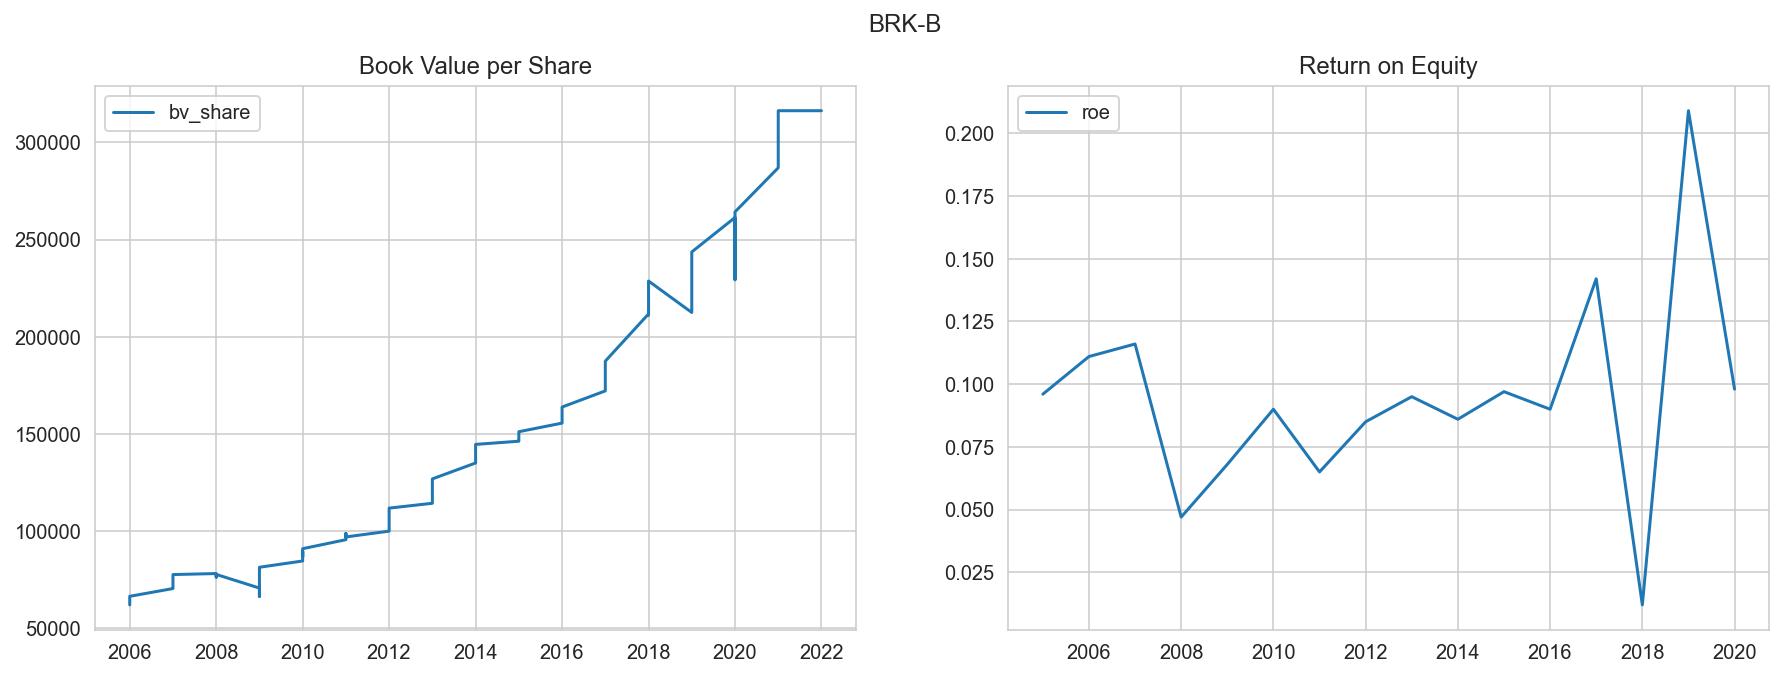

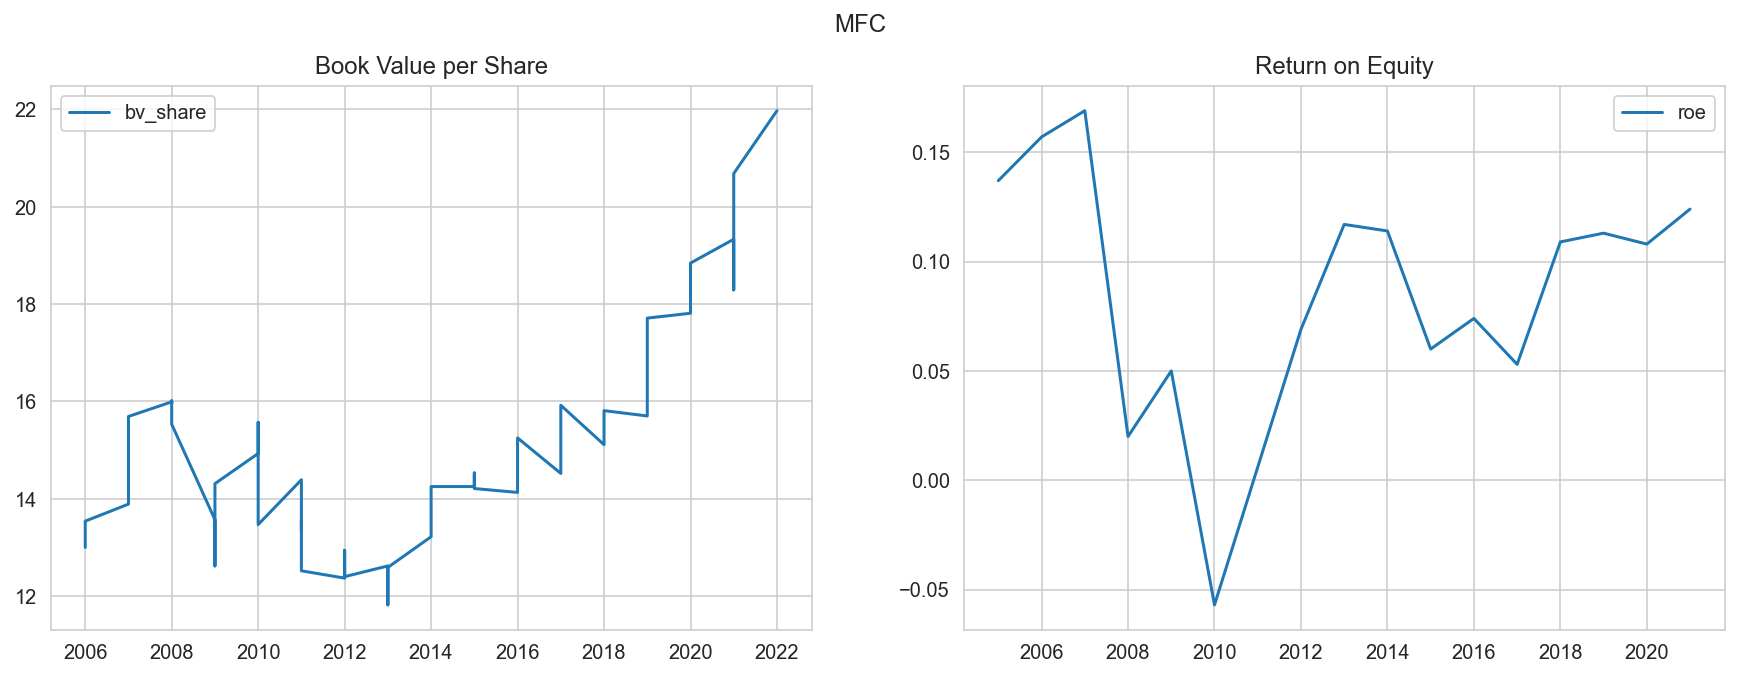

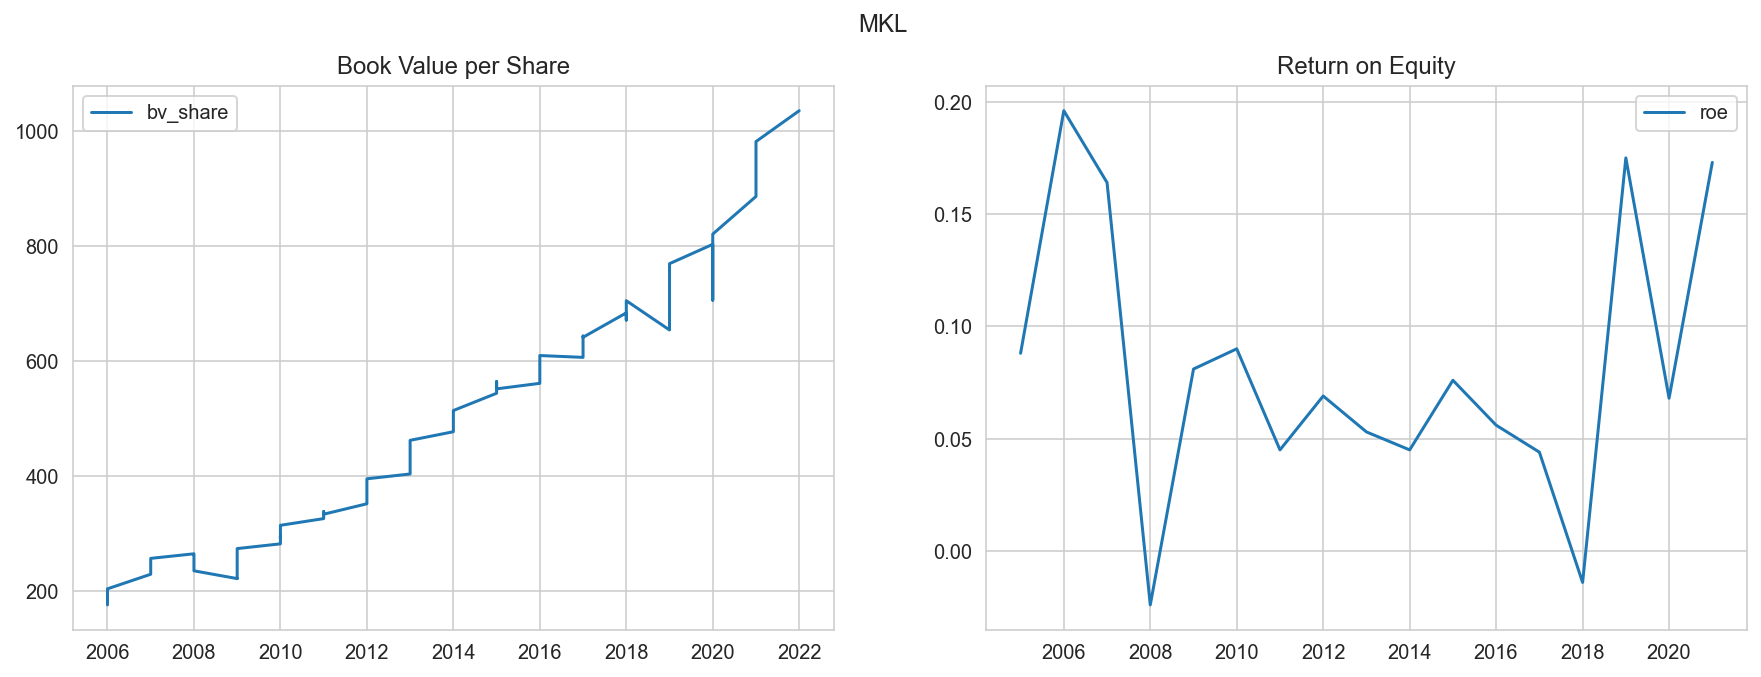

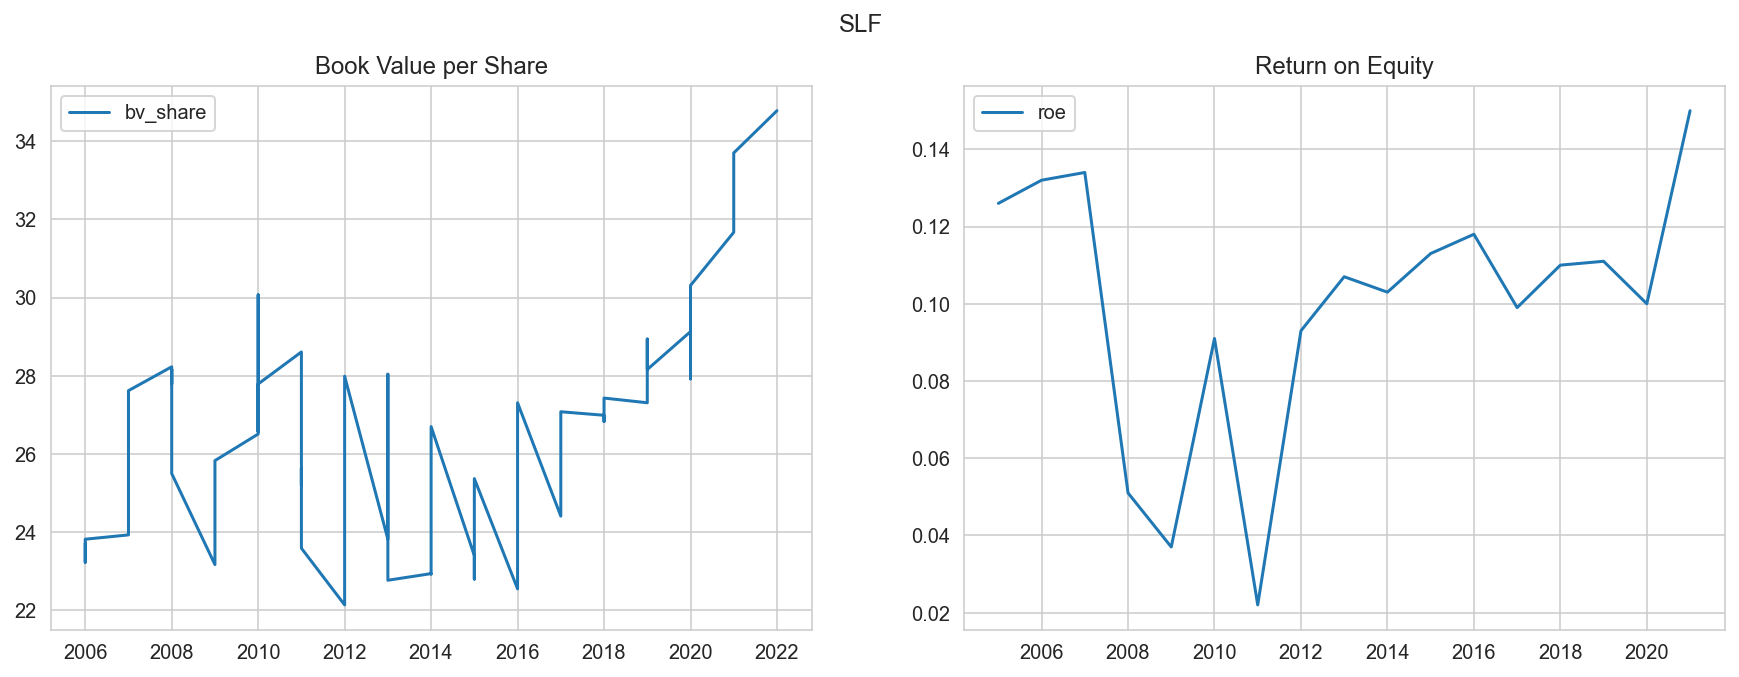

<IPython.core.display.Javascript object>

In [53]:
for key, value in all_data.items():
    plot_financials(value, key)

### Growth Forecasts

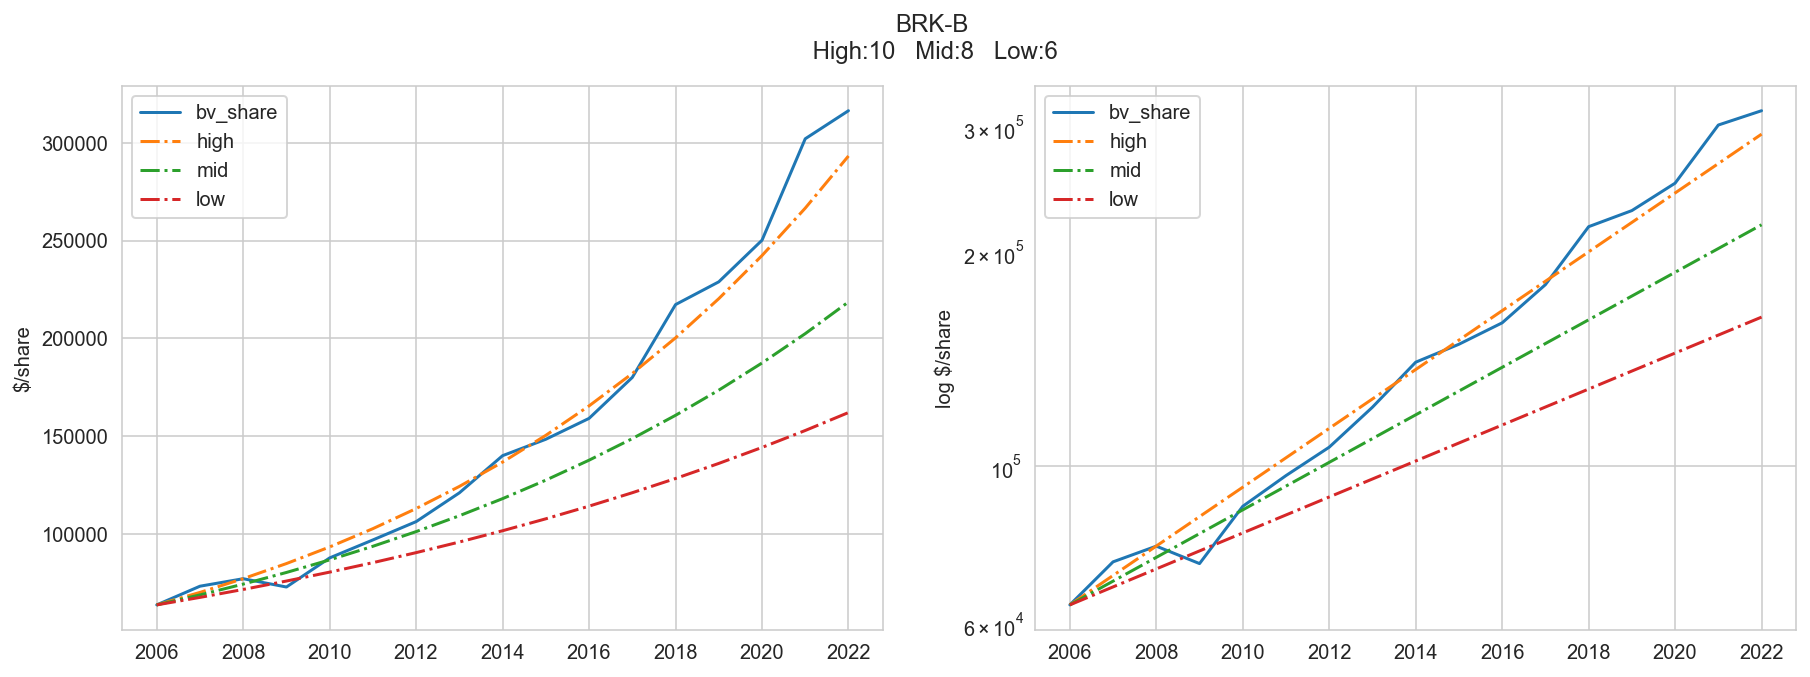

<IPython.core.display.Javascript object>

In [54]:
sensitivity_plot(company_data, "BRK-B", 10, 8, 6, "bv")

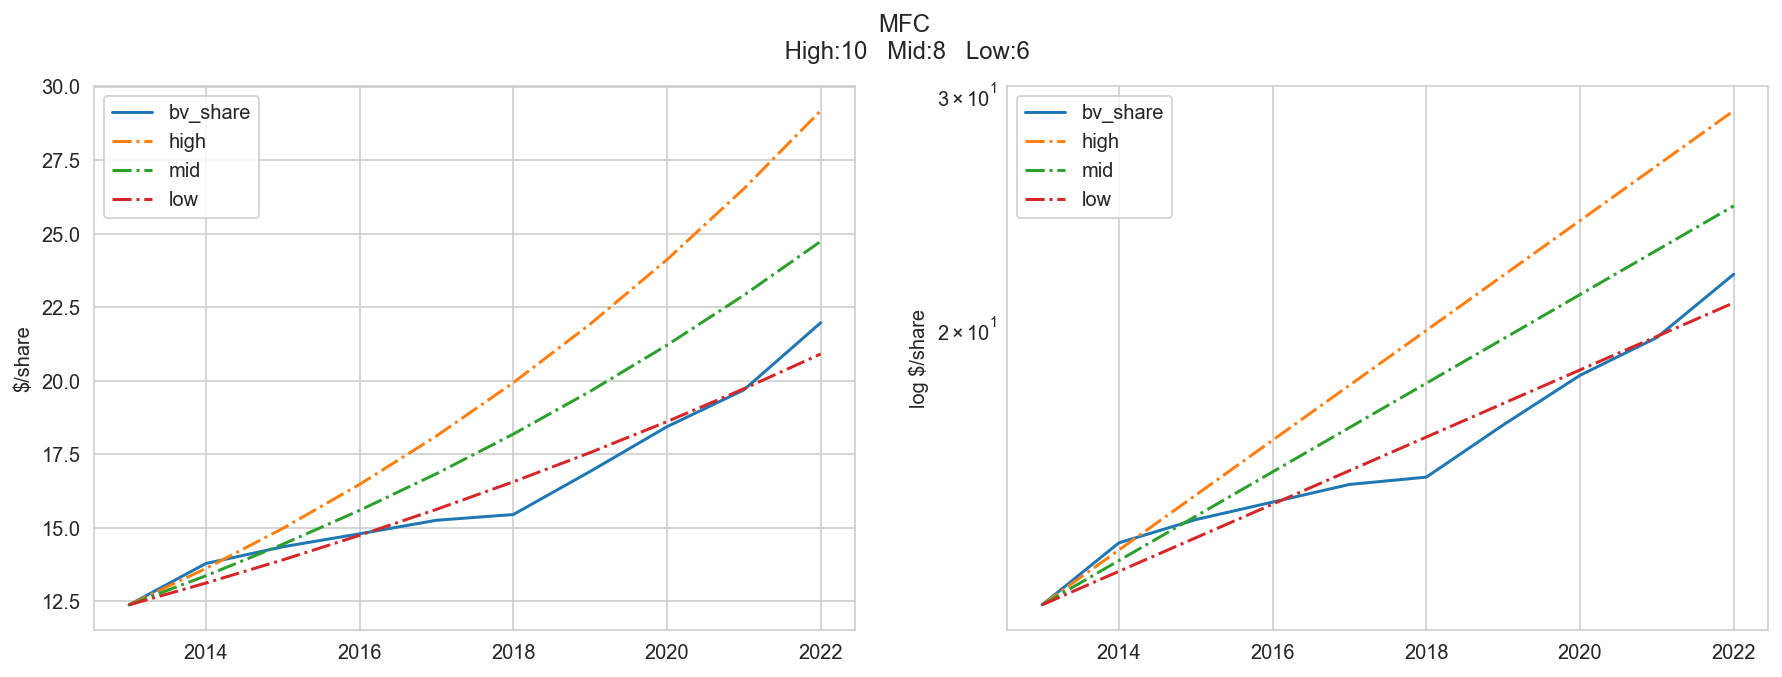

<IPython.core.display.Javascript object>

In [55]:
sensitivity_plot(company_data, "MFC", 10, 8, 6, "bv", start_at=2013)

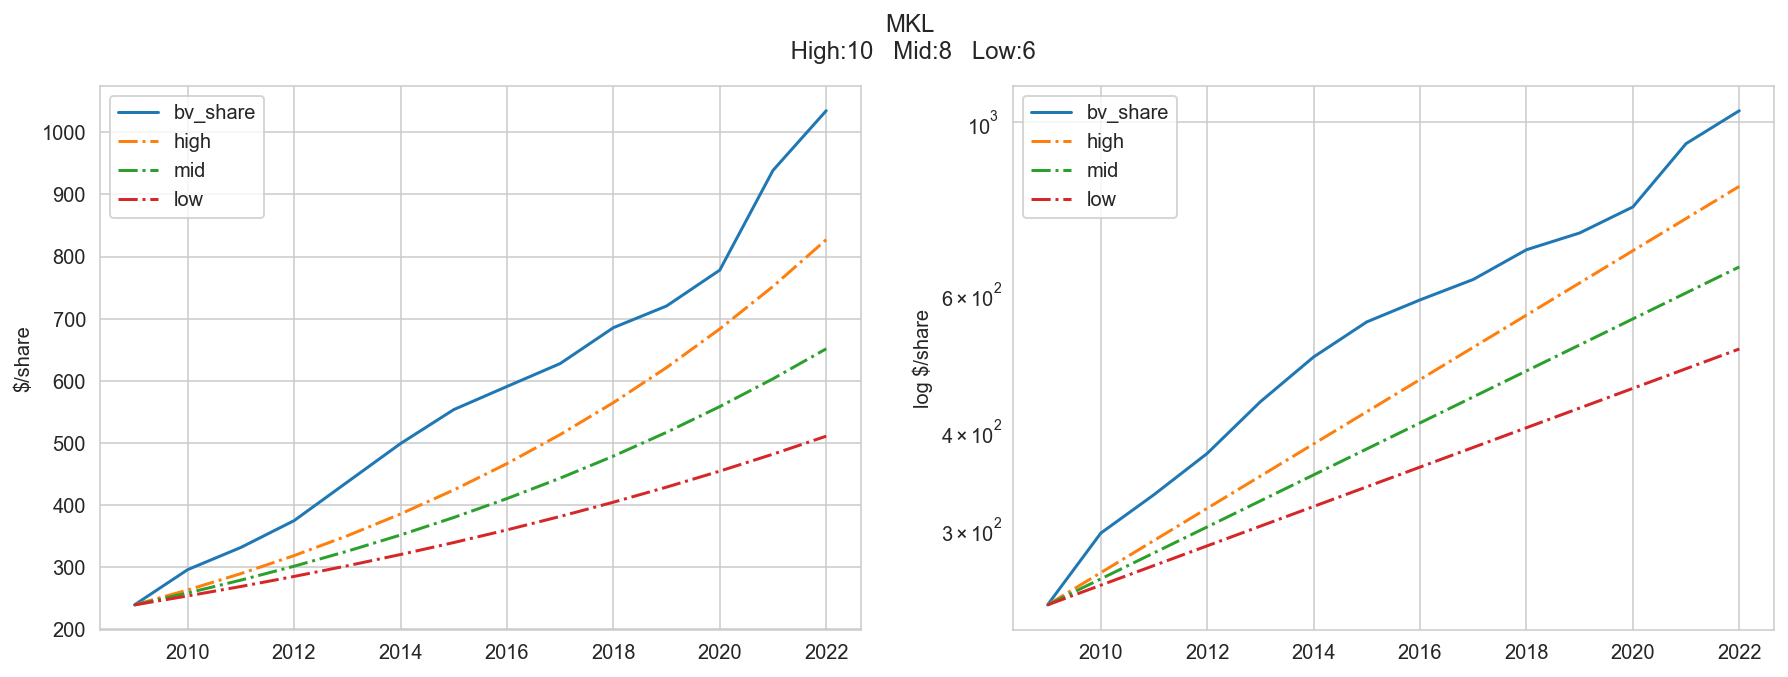

<IPython.core.display.Javascript object>

In [56]:
sensitivity_plot(company_data, "MKL", 10, 8, 6, "bv", start_at=2009)

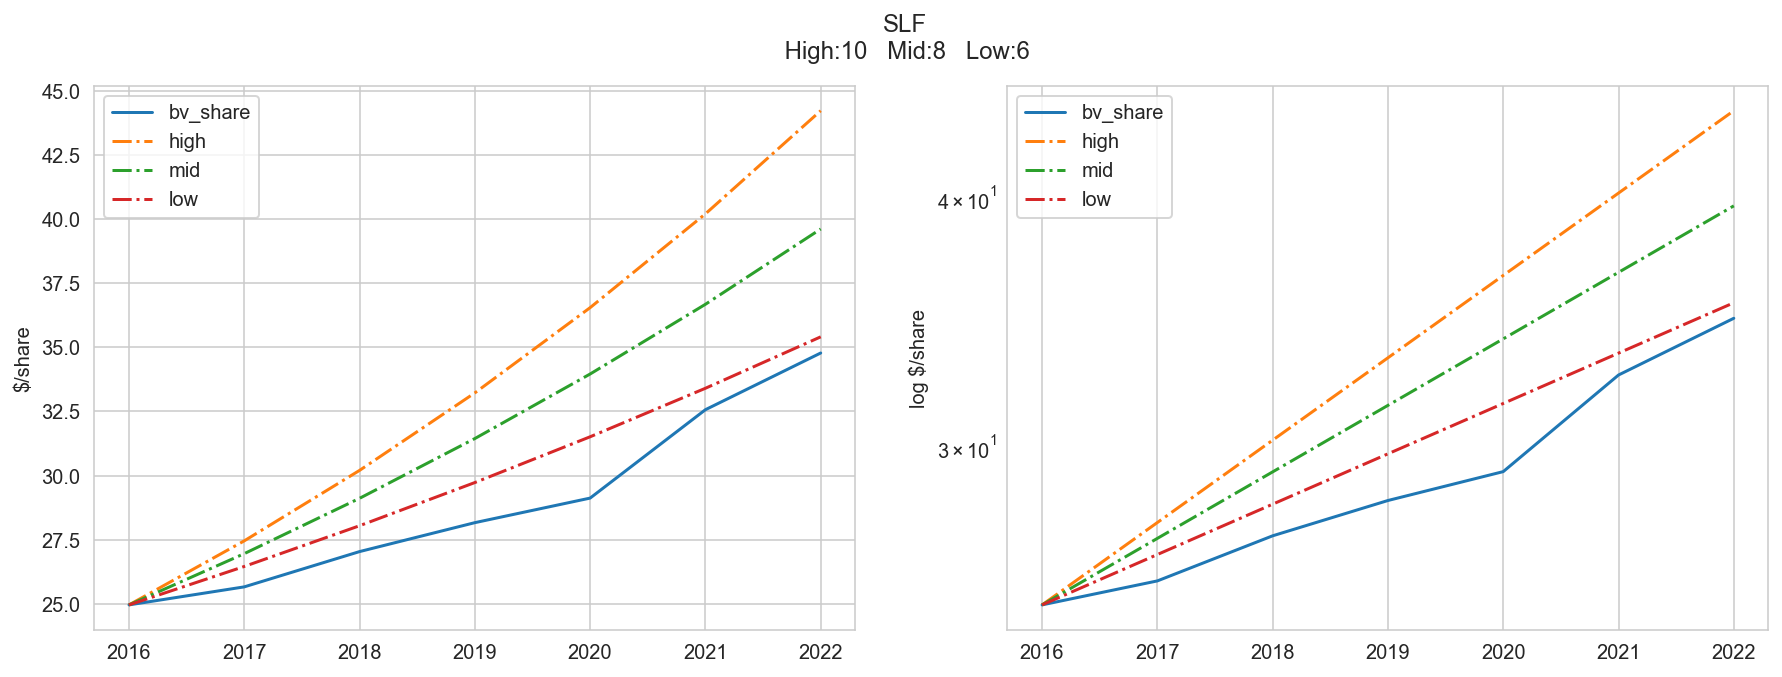

<IPython.core.display.Javascript object>

In [57]:
sensitivity_plot(company_data, "SLF", 10, 8, 6, "bv",start_at=2016)

### ROE Estimates

In [58]:
roe = {}
quantiles = [10, 50, 90]
quantile_name = ['p10','p50','p90']
for ticker, value in all_data.items():
    roe[ticker] ={}
    for p_name, quant in zip(quantile_name, quantiles):
        roe[ticker][f'{p_name}_return_on_equity']= np.percentile(value['return_equity'] * 100,q=100-quant)


<IPython.core.display.Javascript object>

In [59]:
# Transform the dictionary to a dataframe of start values
df_roe = pd.DataFrame.from_dict(
    data=roe, orient="index", columns=["p10_return_on_equity",'p50_return_on_equity','p90_return_on_equity']
)
df_roe = df_roe.reset_index().rename(columns={"index": "ticker"})

<IPython.core.display.Javascript object>

In [60]:
df_roe_out = pd.merge(df_financial, df_roe, left_on='ticker', right_on='ticker')
df_roe_out['p10_terminal'] = 6
df_roe_out['p50_terminal'] = 4
df_roe_out['p90_terminal'] = 2
df_roe_out

,ticker,name,type,currency,p10_return_on_equity,p50_return_on_equity,p90_return_on_equity,p10_terminal,p50_terminal,p90_terminal
0,BRK-B,Berkshire Hathaway,Insurance,USD,12.90,9.25,5.60,6,4,2
1,MFC,Manulife,Insurance,USD,14.50,10.80,1.44,6,4,2
2,MKL,Markel,Insurance,USD,17.38,6.90,2.08,6,4,2
3,SLF,SunLife,Insurance,USD,13.28,10.70,4.54,6,4,2


<IPython.core.display.Javascript object>

### Starting Point Values

In [61]:
# Create a dictionary of starting values for each company
starting_dict = {}
for key, value in company_data.items():
    try:
        starting_dict[key] = value.loc[value.last_valid_index(), "bv_share"]

    except:
        print(key)

<IPython.core.display.Javascript object>

In [62]:
# Transform the dictionary to a dataframe of start values
df_start = pd.DataFrame.from_dict(
    data=starting_dict, orient="index", columns=["start_value"]
)
df_out = df_start.reset_index().rename(columns={"index": "ticker"})

<IPython.core.display.Javascript object>

In [63]:
# View latest start values
df_out

,ticker,start_value
0,BRK-B,316350.56
1,MFC,21.97
2,MKL,1034.56
3,SLF,34.78


<IPython.core.display.Javascript object>

In [64]:
# Override FCF values if needed
# ticker = 'AMZN'
# starting_dict[ticker] = 30 # Assumption: the FCF will jump back to trend prior to covid

# # Transform the dictionary to a dataframe of start values
# df_start = pd.DataFrame.from_dict(
#             data=starting_dict, orient="index", columns=["start_value"]
#         )
# df_out=df_start.reset_index().rename(columns={'index':'ticker'})

<IPython.core.display.Javascript object>

In [65]:
# Final check
df_out

,ticker,start_value
0,BRK-B,316350.56
1,MFC,21.97
2,MKL,1034.56
3,SLF,34.78


<IPython.core.display.Javascript object>

In [66]:
# Export to disk
df_out.to_csv(processed_data / start_file, index=False)
df_roe_out.to_csv(input_data/roe_file, index=False)

<IPython.core.display.Javascript object>